In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import numpy as np
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import re
import traceback

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils import graph
from utils import utils
from nodes.node_functions import *
from utils.models_metadata import *

# playground

# setup

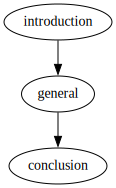

In [2]:
interview_graph = graph.create_screening_interview_flowchart()

graph.plot_graph(interview_graph)

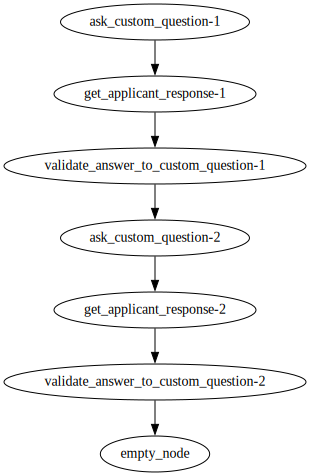

In [3]:
# graph.plot_graph(interview_graph.nodes["algorithm selection"]['graph'])

# graph.plot_graph(interview_graph.nodes["dealing with categorical values"]['graph'])

# graph.plot_graph(interview_graph.nodes["dealing with numerical values"]['graph'])

# graph.plot_graph(interview_graph.nodes["model presentation layer"]['graph'])
# graph.plot_graph(interview_graph.nodes["missing values"]['graph'])
graph.plot_graph(interview_graph.nodes["general"]['graph'])

# run

In [4]:
applicant_approaches = {
    # 'algorithm selection': 'Neural Net',
    # 'categorical encoding': 'hash encoding',
    # 'handling numerical variables': 'standard scaler',
    # 'dealing with missing values': 'Mean Imputation'
}
data_challenge_objectives_and_constraints = ""
# """You are given data for the performance of wind turbines. Your goal is to build a model that can predict whether a turbine will break down within the next 90 days.
# - Maximize model recall."""
# - Model interpretability is not a strong requirement."""

insights = []

what_interviewer_thinks_applicant_has_done_in_ipynb = deepcopy(applicant_approaches)

carryover_data = {
    "applicant_data": {
        "applicant_skill_summary": {
            "technical_depth": np.random.randint(1, 4),
            "technical_breadth": np.random.randint(1, 4),
            "critical_thinking": np.random.randint(1, 4)
        },
        "applicant_context": applicant_approaches,
        'insights': insights,
    },
    "what_interviewer_thinks_applicant_has_done_in_ipynb": what_interviewer_thinks_applicant_has_done_in_ipynb,
    "data_challenge_objectives_and_constraints": data_challenge_objectives_and_constraints,
    "insights": insights,
    'sections': {
        'missing values': {'ask_what_applicant_would_choose_given_requirement': {'prompt_args': {}}},
        'general': {
            # 'ask_custom_question-1': {'prompt_args': {'question': 'What is Regularization?'}},
            # 'validate_answer_to_custom_question-1': {'prompt_args': {'provided_answer': 'Regularization refers to techniques that are used to calibrate machine learning models in order to minimize the adjusted loss function and prevent overfitting or underfitting'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'Advantages of using Random Forest over Linear Regression'}},
            # 'validate_answer_to_custom_question-1': {'prompt_args': {'question': 'Advantages of using Random Forest over Linear Regression'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'Would decreasing the max depth of a decision tree cause it to overfit or underfit?'}},
            # 'validate_answer_to_custom_question-1': {'prompt_args': {'question': 'Would decreasing the max depth of a decision tree cause it to overfit or underfit?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'Between precision and recall, which should you optimize if the objective is to minimize false positives?'}},
            # 'validate_answer_to_custom_question-1': {'prompt_args': {'provided_answer': 'Precision'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'What is the bias variance tradeoff?'}},
            # 'validate_answer_to_custom_question-1': {'prompt_args': {'provided_answer': 'It is the problem of not being able to minimize both bias (underfitting) and variance (overfitting) of a model while training. Reducing one increases the other, and vice versa.'}},
            # 'ask_custom_question-2': {'prompt_args': {'question': "Let's say I run a hypothesis test where alpha is 0.05 and the p-value is 0.1. What conclusion can be drawn about the null hypothesis?"}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'how to reduce overfitting in a random forest model'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'how to reduce overfitting in a decision tree model'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'advantages of using MSE vs RMSE'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'how does a knn classifier work?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'How do you calculate Precision?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'How do you calculate Recall?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'How do you calculate Accuracy?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'A continuous random variable has a bimodal distribution. Out of a violin plot, a boxplot, and a histogram, which is the most effective at visualizing this bimodality and why, if our objective is appropriateness, ease of interpretability, and minimal redundancy?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': "Let's say you have a categorical feature for color. The column has 900 unique values. If using a tree-based model, what is the most optimal way (based on correctness, and space and time complexity) to represent this feature, and why?"}}
            # 'ask_custom_question-1': {'prompt_args': {'question': "Let's say I run a hypothesis test where alpha is 0.05 and the p-value is 0.01. What conclusion can be drawn?"}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'intuitive explanation of gradient descent'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'what activation function should you use for a multiclass classifcation neural network?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'What is the difference between and stack and a queue?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'How does quicksort work?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'What is inheritance in programming?'}},
            # 'ask_custom_question-1': {'prompt_args': {'question': 'How does a hash table work'}},
            'ask_custom_question-1': {'prompt_args': {'question': "Can you explain how the 'this' keyword works in JavaScript"}},
            'ask_custom_question-2': {'prompt_args': {'question': "Why is it important to design an API endpoint to be idempotent?"}},




        },
    },
}

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = []
flattened_chat_history = ""

# list of the nodes that have been visited till the current point
sections_visited_names = []
nodes_visited_names = []

validate_async = False
is_interview_complete = False


current_section_name, current_section = graph.get_first_node_in_graph(interview_graph)
current_section_graph = current_section['graph']

In [5]:
# TODO: logic to assert that there is a question in the prompt args of any `ask_custom_question` node in carryover data.

In [5]:
try:
    # traverse through sections
    while not is_interview_complete:
        chat_history_by_section.append([])
        current_node_name, current_node = graph.get_first_node_in_graph(current_section_graph)
        # print("\n\ncurrent section: " + current_section_name)
        # print("current node: " + current_node_name)
        is_section_complete = False
        # traverse within section
        while not is_section_complete:
            # access current node from current section
            # prep args for current node function
            current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
            current_node_function_args['current_node_name'] = current_node_name
            current_node_function_args['current_section_name'] = current_section_name
            current_node_function_args['model_name'] = current_node['function'].__name__
            current_node_function_args['carryover_data'] = carryover_data
            current_node_function_args['validate_async'] = validate_async
            current_node_function_args['chat_history_by_section'] = chat_history_by_section

            # call function
            current_node_output = current_node['function'](**current_node_function_args)
            
            if current_node_output['new_chat_lines']:
                # store return values in appropriate variables (chat_history)
                chat_history_by_section[-1].extend(current_node_output['new_chat_lines'])
                flattened_chat_history += "\n" + "\n".join(current_node_output['new_chat_lines'])
                clear_output()
                print(flattened_chat_history)
        
            # update nodes_visited
            nodes_visited_names.append(current_node_name)
        
            # figure out next node to visit
            current_node_name, current_node = graph.get_next_node(current_section_graph, current_node_name, current_node_output)
            if current_node_name is None:
                # prepare routing_value (result of a section)
                current_section_output = dict(routing_value=1, 
                                            new_chat_line=None) 
                is_section_complete = True

        
        sections_visited_names.append(current_section_name)
        # get new section
        current_section_name, current_section = graph.get_next_node(interview_graph, current_section_name, current_section_output)
        if current_section_name is None:
            is_interview_complete = True
            break
        current_section_graph = current_section['graph']
except:
    traceback.print_exc()


Interviewer: Thank you for taking the time out to interview with us. 
    In this interview, we will cover a range of topics and ask questions to assess your skill level as a Data Scientist. 
    If you don't understand a question, feel free to ask questions to get clarification.
    Let's get started.
Interviewer: Could you explain how the 'this' keyword works in JavaScript?
Applicant: The “this” keyword refers to an object that is executing the current piece of code.
Interviewer: Why is it important to design an API Endpoint to be Idempotent?
Applicant: It ensures that hitting the same endpoint always gives the same result.
Interviewer: Okay, those were all the topics we wanted to cover. Thank you again for taking the time out to interview with us.
    We will get back to you with our decision. Have a nice day!


In [7]:
# prepare_data.validate_observations_for_finetuning_from_queue()

# debug

In [8]:
current_node_name

In [9]:
# try:
#     # interview_graph.nodes["algorithm selection"]['graph'].nodes['ask_how_it_works']['function_args']['subject'] = "DBSCAN"

#     # current_node = interview_graph.nodes["algorithm selection"]['graph'].nodes["validate_why_applicant_picked_X_over_Y"]

#     current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
#     current_node_function_args['carryover_data'] = carryover_data
#     current_node_function_args['current_section_name'] = "dealing with numerical values"
#     current_node_function_args['validate_async'] = False
#     # current_node_function_args['chat_history_by_section'] = [
#     #     ["""Interviewer: Could you confirm whether you used a Generative Adversarial Network for this task?
#     # Applicant: Yes, I used a Generative Adversarial Network for this task.
#     # Interviewer: How does a Generative Adversarial Network work?
#     # Applicant: GANs are deep learning models that produce fake data.
#     # Interviewer: Besides GANs, did you consider any other algorithms for this task?
#     # Applicant: Yes, I considered using autoencoders and also CNNs."""]
#     # ]
#     current_node_function_args['chat_history_by_section'] = chat_history_by_section

#     current_node_output = current_node['function'](**current_node_function_args)
# except:
#     traceback.print_exc()
